# Root Insurance Erdos Data Camp Project

## Import packages 

In [28]:
# Import the package and data
import pandas as pd
import numpy as np 

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## 1. Summary statistics

In [29]:
## check the data 
df = pd.read_csv('../0-data/Root_Insurance_data.csv')
df.head()

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0


In [13]:
## check the dataframe infor
df.info()
print()

## check the columns
print(df.columns)
print()

## check the dimension
print(df.shape)
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Currently Insured   10000 non-null  object 
 1   Number of Vehicles  10000 non-null  int64  
 2   Number of Drivers   10000 non-null  int64  
 3   Marital Status      10000 non-null  object 
 4   bid                 10000 non-null  float64
 5   rank                10000 non-null  int64  
 6   click               10000 non-null  bool   
 7   policies_sold       10000 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 556.8+ KB

Index(['Currently Insured', 'Number of Vehicles', 'Number of Drivers',
       'Marital Status', 'bid', 'rank', 'click', 'policies_sold'],
      dtype='object')

(10000, 8)



In [14]:
## check the correlation
df.corr()

,Number of Vehicles,Number of Drivers,bid,rank,click,policies_sold
Number of Vehicles,1.000000,-0.029474,NaN,0.399393,-0.171822,-0.130380
Number of Drivers,-0.029474,1.000000,NaN,-0.076289,0.021604,-0.005525
bid,NaN,NaN,NaN,NaN,NaN,NaN
rank,0.399393,-0.076289,NaN,1.000000,-0.416046,-0.262496
click,-0.171822,0.021604,NaN,-0.416046,1.000000,0.606136
policies_sold,-0.130380,-0.005525,NaN,-0.262496,0.606136,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Currently Insured   10000 non-null  object 
 1   Number of Vehicles  10000 non-null  int64  
 2   Number of Drivers   10000 non-null  int64  
 3   Marital Status      10000 non-null  object 
 4   bid                 10000 non-null  float64
 5   rank                10000 non-null  int64  
 6   click               10000 non-null  bool   
 7   policies_sold       10000 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 556.8+ KB


In [20]:
df.columns

Index(['Currently Insured', 'Number of Vehicles', 'Number of Drivers',
       'Marital Status', 'bid', 'rank', 'click', 'policies_sold'],
      dtype='object')

In [6]:
df.shape

(10000, 8)

In [30]:
## INCOMPLETE: Brian Working from here tomorrow
### Note: Create categorical (factor) versions of descriptors
varlist = ["Currently Insured", "Number of Vehicles", "Number of Drivers", "Marital Status"]
for i in varlist:
    j     = i + "_Cat"
    df[j] = pd.Categorical(df[i])
    
### Note: Create dummies for Different Vars
df["Married"]                = pd.get_dummies(df["Marital Status"])["M"]
df[["Insured", "Uninsured"]] = pd.get_dummies(df["Currently Insured"])[["Y", "N"]]
df["MultDrivers"]            = pd.get_dummies(df["Number of Drivers_Cat"])[2]
df[["TwoVehicles", "ThreeVehicles"]] = pd.get_dummies(df["Number of Vehicles"])[[2, 3]]

### Note: Create Unique Identifier for groups; count instances
temploc  = df.columns.get_loc("Married")
temploc2 = len(df.columns)-1
df_temp  = df.iloc[:,temploc:temploc2].drop_duplicates().reset_index(drop = True)
df_temp  = df_temp.astype(str)

df_temp.shape

df["Group"] = ""
for i in range(0,df_temp.shape[0]):
    for j in range(0,df.shape[0]):
        tempvec  = ''.join(df_temp.iloc[i,].values)
        tempvec2 = ''.join(df.iloc[j,temploc:temploc2].astype(str).values)
        if tempvec == tempvec2:
            df.iloc[j,df.shape[1]-1] = i


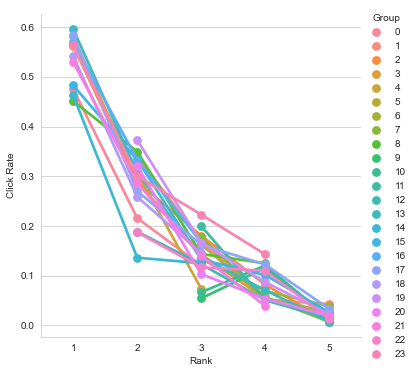

In [91]:
groups = df.Group.value_counts()

group_propensities = df.groupby(["Group", "rank"])["click"].mean().unstack()
group_propensities.reset_index(inplace=True)
group_propensities.columns
gp_r = group_propensities.melt(id_vars=["Group"],
                               var_name = "Rank",
                               value_name = "Click Rate")

index_names = gp_r[pd.isna(gp_r["Click Rate"])].index
gp_r.drop(index_names)
sns.catplot(x = "Rank",
            y = "Click Rate",
            hue = "Group",
            data = gp_r,
            kind = "point")

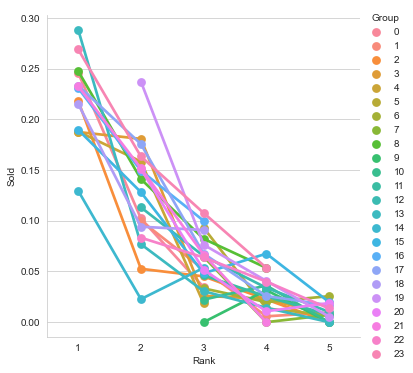

In [92]:
group_propensities = df.groupby(["Group", "rank"])["policies_sold"].mean().unstack()
group_propensities.reset_index(inplace=True)
group_propensities.columns
gp_r = group_propensities.melt(id_vars=["Group"],
                               var_name = "Rank",
                               value_name = "Sold")

index_names = gp_r[pd.isna(gp_r["Sold"])].index
gp_r.drop(index_names)
sns.catplot(x = "Rank",
            y = "Sold",
            hue = "Group",
            data = gp_r,
            kind = "point")

In [ ]:
insured = df.groupby(['rank', 'policies_sold'])['Currently Insured'].count()
import seaborn 
from matplotlib import pyplot as plt
insured.unstack().plot()
plt.xticks(rotation=45)
plt.title("Currently insured count")
plt.show()


In [ ]:
insured = df.groupby(['rank', 'click'])['Currently Insured'].count()
import seaborn 
from matplotlib import pyplot as plt
insured.unstack().plot()
plt.xticks(rotation=45)
plt.title("Currently insured count")
plt.show()

In [ ]:
vehicle = df.groupby(['rank', 'policies_sold'])['Number of Vehicles'].mean()
import seaborn 
from matplotlib import pyplot as plt
vehicle.unstack().plot()
plt.xticks(rotation=45)
plt.title("number of vehicle mean")
plt.show()

In [ ]:
drivers = df.groupby(['rank', 'policies_sold'])['Number of Drivers'].mean()
import seaborn 
from matplotlib import pyplot as plt
drivers.unstack().plot()
plt.xticks(rotation=45)
plt.title("Number of Drivers mean")
plt.show()

In [ ]:

        
Marital = df.groupby(['rank', 'policies_sold'])['Marital Status'].count()
import seaborn 
from matplotlib import pyplot as plt
Marital.unstack().plot()
plt.xticks(rotation=45)
plt.title("Marital Status count")
plt.show()

In [ ]:

        
click = df.groupby(['rank', 'policies_sold'])['click'].count()
import seaborn 
from matplotlib import pyplot as plt
click.unstack().plot()
plt.xticks(rotation=45)
plt.title("click count")
plt.show()

descriptive information about variables by rank 

In [ ]:
## summary statistics of all other variables based on Rank  
df.groupby(['rank']).agg(
{'Currently Insured':"count",
 'Number of Vehicles':[min,max,sum],
 'Number of Drivers':[min,max,sum],
 'Marital Status':"count",
 'click':"count",
 'policies_sold':"sum"
}
)

In [ ]:
df.groupby(['rank']).describe()

In [ ]:
df.groupby(['rank'])['Number of Vehicles'].mean()

In [ ]:
df.groupby(['rank'])['Number of Drivers'].mean()

In [ ]:
df.groupby(['rank'])['Policies_sold'].mean()

In [ ]:
df.groupby(['rank'])['Currently Insured'].mean()

In [ ]:
## summary statistics of all other variables based on Rank and Click 
df.groupby(['rank','click']).agg(
{'click':"sum",
 'Currently Insured':"count",
 'Number of Vehicles':[min,max,sum],
 'Number of Drivers':[min,max,sum],
 'Marital Status':"count",
 'policies_sold':"sum"
}
)

# any thoughts here? feel free to add yours 
# company can sell the policy only if the ad is clicked 
# increase the rank based on attributes 
# we can just ignore default price here? cause it doesn't matter

In [ ]:
## calculate click-through-rate (CTR)
### It is the ratio of sum of the number of clicks over the number of total observations.
ctr = df.click.value_counts("True")
print(ctr)

In [ ]:
### Note: Plot distributions for 

## 2. Simple logistic regression

In [ ]:
## import the package
import statsmodels.api as sm

In [ ]:
## Data clean
## Currently Insured: categorical/unknow, N, Y
## Number of Vehicles: ordinal
## Number of Drivers: ordinal
## Marital Status: categorical/ M, S
## rank: ordinal

## There are two ways to run regressions when having categorial variables in datasets.
## 1. Delete those categorical variables.
## 2. Keep them but generate dummy variables. 
## since we don't have much features in our dataset, i would go for dummies.

## Create dummies for Currently Insured and Marital Status. 
## 1. For Currently Insured, i left "unknow" as baseline case. So Insured_N, and Insured_Y are created and included. 
## 2. For Marital Status, i left "S" as baseline case. So Married are created and included. 
## For the other variables I would treat them as ordinal.

pd.get_dummies(df['Currently Insured'])
df['Insured_N'] = pd.get_dummies(df['Currently Insured'])['N']
df['Insured_Y'] = pd.get_dummies(df['Currently Insured'])['Y']

pd.get_dummies(df['Marital Status'])
df['Married'] = pd.get_dummies(df['Marital Status'])['M']

pd.get_dummies(df['click'])
df['click_true'] = pd.get_dummies(df['click'])[True]

df.head()


### 2.1. click 

#### 2.1.1 click without interactions

In [ ]:
## define X and Y

X = df[['Insured_N', 'Insured_Y', 'Number of Vehicles', 'Number of Drivers', 'Married','rank']].copy()
X = sm.add_constant(X)
y = df['click_true'].copy()

## define and fit the model
model = sm.Logit(y, X)
result = model.fit(method='newton')


In [ ]:
## result summary
result.summary()

#### 2.1.1 click with interactions

### 2.2. policies_sold

#### 2.2.1. policies_sold without interactions

In [ ]:
## 2.2 the outcome variable is "policies_sold"
y = df['policies_sold'].copy()

## define and fit the model
model = sm.Logit(y, X)
result = model.fit(method='newton')



In [ ]:
y = df['policies_sold'].copy()

## define and fit the model
model = sm.Logit(y, X)
result = model.fit(method='newton')

#### 2.2.1 policies_sold with interactions

## 3. Classification

### 3.1 Logistic regression

In [ ]:
## 3.1 Logistic regression
## import the package 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Accuracy
from sklearn.metrics import accuracy_score
## Precision
from sklearn.metrics import precision_score
## Recall
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
## train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=.2,
                                                shuffle=True,
                                                random_state=614,
                                                stratify=y)

In [ ]:
## fit the model by using train dataset
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

In [ ]:
def get_acc(y_pred,y_actual):
    return np.sum(y_pred == y_actual)/len(y_actual)

In [ ]:
## cross validation
kfold = StratifiedKFold(5,shuffle=True,random_state=440)


## cut-offs 
cutoffs = np.arange(0,1,.01)

accs = np.zeros((5,len(cutoffs)))
log_reg = LogisticRegression()

i = 0

for train_index,test_index in kfold.split(X_train,y_train):
    X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    
    
    for j in range(len(cutoffs)):
        log_reg_clone = clone(log_reg)
        log_reg_clone.fit(X_train_train,y_train_train)
        probs = log_reg_clone.predict_proba(X_train_test)[:,1]
        
        y_pred = 1*(probs > cutoffs[j])
        accs[i,j] = get_acc(y_pred,y_train_test)
        
    i=i+1

In [ ]:
## plot the figure

plt.figure(figsize=(10,8))


plt.plot(cutoffs,np.mean(accs,axis=0))

plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.show()

In [ ]:
print("The cutoff with highest mean CV accuracy was",
         cutoffs[np.argmax(np.mean(accs,axis=0))])